A lot of people are using statistical hypothesis testing without knowing it. Everytime somebody does a A/B test, what they are doing is testing a hypothesis. There are many pits you can fall into when doing hypothesis testing, some of them obvious (do enough tests and you will find something!), some of them more subtle. One of the more subtle points is that you can not stop your experiment early.

It is tempting to start collecting data and when you see the p-value drop to a low value declare: Hooray, this new button is working! People are signing up in record numbers! If you do this you are kidding yourself. This post will explain why this is the wrong thing to do.

While it might be new and fashionable to use A/B testing, hypothesis testing itself has been around for a long time. It is used (and abused) in medical trials and High Energy Particle Physics all the time. This means most traps have been discovered before, there is no need for A/B testers to rediscover them. Just one recent example: [Experiments at AirBnB](http://nerds.airbnb.com/experiments-at-airbnb/) by the mighty [AirBnB](http://airbnb.com). They like stopping their experiments early and provide a little glance at what methodology they use to do that. There is not enough information in the post to show that their method works, but let's assume it does. One thing not covered is what stopping early does to the power of your test.

If you need a refresher on hypothesis testing, take a look at a previous post of mine: [When to switch?](/posts/when-to-switch/). It also explains what the power of your test is.

In [2]:
%matplotlib inline

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.stats as stats
import random

random.seed(12345)
np.random.seed(5345436)

The first thing we need is a set of observations. In this experiment you measure the conversion rate on your website. The average conversion rate is 6%. The first set of observations will always have an average conversion rate of 6%, using the `difference` parameter we can decide how big the difference between the two samples should be. This is handy as it allows us to generate a set of observations where the true difference is zero, or any other value we would like to investigate. We can also set how big the samples should be (how many observations there are).

We use Student's t-test to calculate the p-value for each experiment.In this example we want to know if the changes to our website improved the conversion rate or not. The p-value is the probability of the mean in the second sample being bigger than the mean in the first sample due to nothing else but chance. In this case you can calculate the p-value by using [Student's t-test](http://en.wikipedia.org/wiki/Student%27s_t-test).

In [15]:
def two_samples(difference, N=6500, delta_variance=0.):
    As = np.random.normal(6., size=N)
    Bs = np.random.normal(6. + difference, scale=1+delta_variance, size=N)
    return As, Bs

def one_sided_ttest(A, B, equal_var=True):
    t,p = stats.ttest_ind(A, B, equal_var=equal_var)
    # the t-test implemented in scipy is two sided, but we are interested
    # in the one sided p-value, hence this if statement and the divide by two.
    if t < 0:
        p /= 2.
    else:
        p = 1- p/2.

    return p

Time to run an experiment. Let's assume that in total you collect 100 observations in each group. To see what happens with the p-value as we collect the data we will plot it after each a new observation has been collected in each group.

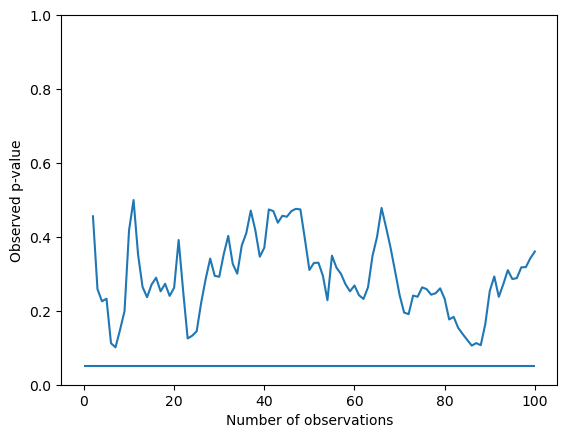

In [18]:
# There is no difference between the two samples
As, Bs = two_samples(0., N=100)
p_vals = []
for n in range(len(As)-1):
    n += 2
    p_vals.append(one_sided_ttest(As[:n], Bs[:n]))

a = plt.axes()
a.plot(np.arange(len(As)-1)+2, p_vals)
a.set_ylabel("Observed p-value")
a.set_xlabel("Number of observations")
a.set_ylim([0., 1.])
a.hlines(0.05, 0, 100)

plt.show()

As you can see it varies quite a bit over the course of the experiment. While in this particular case it never dipped below 0.05, you do not have to rerun that cell too often to find one where it does.

If you were to do a large number of experiments where you show the same webpage to both groups and plot the p-value you see you would get the following:

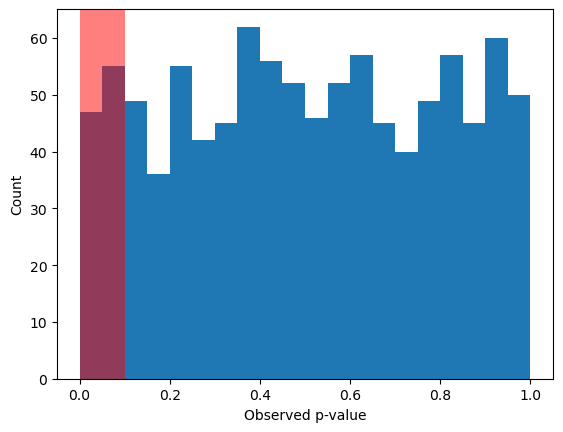

In [23]:
def repeat_experiment(repeats=1000, diff=0.):
    p_values = []
    for i in range(repeats):
        A,B = two_samples(diff, N=100)
        p = one_sided_ttest(A,B)
        p_values.append(p)
    
    plt.hist(p_values, range=(0,1.), bins=20)
    plt.axvspan(0., 0.1, facecolor="red", alpha=0.5)
    plt.xlabel("Observed p-value")
    plt.ylabel("Count")
    plt.show()
    
repeat_experiment()

As you can see 10% of your observed p-values fall into the red area. Similarly 5% of your experiments will give you a p-value of less than 0.05. All despite there being no difference!

This brings us to what exactly the hypothesis testing procedure does for you. By choosing to declare victory when you observe a p-value below 0.05 you are saying: In the long run, over many repeats of this experiment there is only a 5% change of declaring victory when I should not.

This is important. It does not tell you how likely it is that you have truely found something. It does not even tell you whether in this particular instance you are making the right choice. Only that in the long run, over many repeats of this experiment you will be wrong 5% of the time.

So what does stopping early do to this?

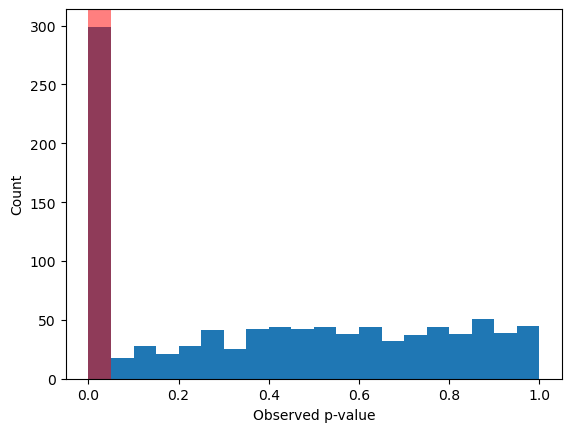

In [25]:
def repeat_early_stop_experiment(repeats=1000, diff=0.):
    p_values = []
    for i in range(repeats):
        A,B = two_samples(diff, N=100)

        for n in range(len(A)-1):
            n += 2
            p = one_sided_ttest(A[:n], B[:n])
            if p < 0.05:
                break
            
        p_values.append(p)
    
    plt.hist(p_values, range=(0,1.), bins=20)
    plt.axvspan(0., 0.05, facecolor="red", alpha=0.5)
    plt.xlabel("Observed p-value")
    plt.ylabel("Count")
    plt.show()
repeat_early_stop_experiment()

You see a small p-value, stop the experiment, declare victory and have a celebratory beer. Only to wake up with a massive hangover and a webpage which you think is better but actually is not.

Even worse you have lost the only thing that the hypothesis testing procedure does for you. Namely, you see a p-value below 0.05 many more times than 5% of all experiments (1000 * 0.05 = 50). In the long run you will not be wrong only 5% of the time, but more often.

So what about the power then? The power of a test is defined as the probability that you change your mind/website when you should do so. Phrased differently: if the alternative website is better, how likely are you to detect that? This depends on how big the difference between the two is and how many observations you make. The larger the improvements, the easier they are to detect. If B increases your conversion rate from 6 to 20%, you will spot that much easier than if it only changes it from 6 to 7%.

Let's take a look what happens if you stop your experiments early.

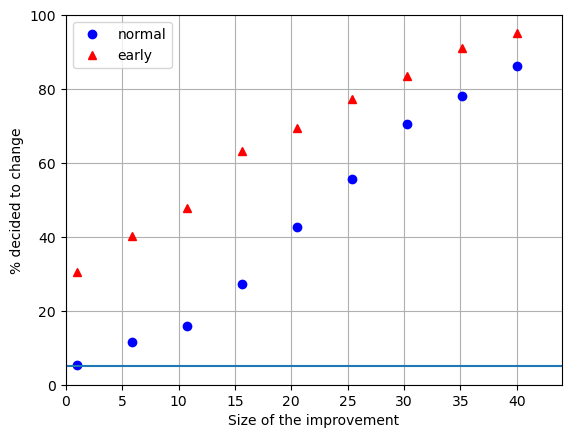

In [27]:
def keep_or_not(improvement, threshold=0.05, N=100, repeats=1000, early_stop=False):
    keep = 0
    for i in range(repeats):
        A,B = two_samples(improvement, N=N)

        if early_stop:
            for n in range(len(A)-1):
                n += 2
                p = one_sided_ttest(A[:n], B[:n])
                if p < 0.05:
                    break

        else:
            p = one_sided_ttest(A, B)
            
        if p <= threshold:
            keep += 1
            
    return float(keep)/repeats

def power_plot(improvements, normal_keeps, early_keeps):
    plt.plot(improvements, normal_keeps, "bo", label="normal")
    plt.plot(improvements, early_keeps, "r^", label="early")
    
    plt.legend(loc="best")
    plt.ylim((0, 100))
    plt.xlim((0, improvements[-1]*1.1))
    plt.grid()
    plt.xlabel("Size of the improvement")
    plt.ylabel("% decided to change")
    plt.axhline(5)

improvements = np.linspace(1., 40, 9)

keeps = []
early_keeps = []
for improvement in improvements:
    keeps.append(keep_or_not(improvement/100.)*100)
    early_keeps.append(keep_or_not(improvement/100., early_stop=True)*100)

power_plot(improvements, keeps, early_keeps)

This suggests that by stopping your experiment early you change your webpage to the alternative more often when there really is an effect! If the improvement is from 6% to 7% you are almost six times more likely to correctly change your mind.

Surely this is a good thing. Not so fast! The reason it looks like stopping early boosts your chances of discovery is because we are not looking at the false positive rate. As we saw before, if you stop early you incorrectly change your website more often than 5% of the time. The power of a test also depends on how often you want to be wrong. If you have no problem being wrong all the time, then the best strategy is to always switch. You will correctly switch 100% of the time.

What is the true false positive rate of the early stopping strategy?

In [30]:
def false_positives(repeats=1000, early_stop=False, threshold=0.05):
    switches = 0
    for i in range(repeats):
        A,B = two_samples(0., N=100)

        if early_stop:
            for n in range(len(A)-1):
                n += 2
                p = one_sided_ttest(A[:n], B[:n])
                if p < threshold:
                    break
                    
        else:
            p = one_sided_ttest(A, B)
        
        if p < threshold:
            switches += 1

    return float(switches)/repeats

print("Normal stopping strategy:", false_positives())
print("Early stopping strategy:", false_positives(early_stop=True))

Normal stopping strategy: 0.046
Early stopping strategy: 0.319


When making the decision after all observations have been collected the false positive rate is indeed close to 5%, as promised by the hypothesis testing procedure. For the early stopping method you end up with a false positive rate of something around 30%!

How much lower do we have to make the p-value threshold with the early stopping strategy in order to have the same false positive rate of 5%?

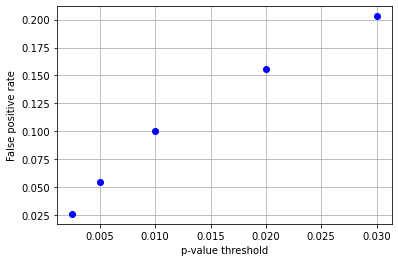

In [11]:
thresholds = (0.0025, 0.005, 0.01, 0.02, 0.03)
fp_rates = [false_positives(threshold=p, early_stop=True) for p in thresholds]

plt.plot(thresholds, fp_rates, "bo")
plt.xlabel("p-value threshold")
plt.ylabel("False positive rate")
plt.grid()

The threshold to use when stopping an experiment early has to be much, much lower than 0.05 to achieve the same actual false positive rate. Now we can re-run our comparison of the power of the two tests (normal and early stopping). Below we have the power of both tests for a false positive rate of 5%.

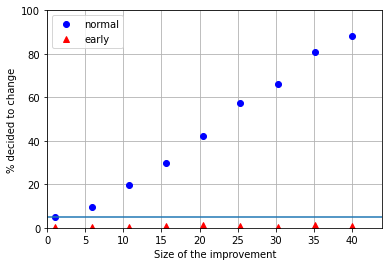

In [12]:
improvements = np.linspace(1., 40, 9)

keeps = []
early_keeps = []
for improvement in improvements:
    keeps.append(keep_or_not(improvement/100.)*100)
    early_keeps.append(keep_or_not(improvement/100.,
                                   early_stop=True,
                                   threshold=0.005)*100)

power_plot(improvements, keeps, early_keeps)

Exactly that! You almost never decide to change to the new webpage. By stopping early and insisting on the same overall false positive rate you are making your test less powerful.

The most common reason given for wanting to stop early is that you would not possibly want to miss out on an opportunity. By switching to the new design earlier, more customers will see it and as a result more of them will end up giving you their money. Turns out that by wanting to stop early you end up never switching your website, even if it is clearly better!

The conclusion is that by trying to be smarter than generations of statisticians you are very likely to make things worse. You have to be very careful with what you are doing, to actually improve on the standard prescription of how to run an A/B test. Read some more about this and related problems on wikiepdia: [Sequential analysis](https://en.wikipedia.org/wiki/Sequential_analysis)